<a href="https://colab.research.google.com/github/Ajay-ee13/ML-in-finance/blob/main/1.Stock%20Price%20Prediction/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

One of the biggest challenges in finance is predicting stock prices. Machine learning techniques naturally lend themselves to stock price prediction based 
on historical data. Predictions can be made for a single time point ahead or for a set of future time points.

other than the historical price of the stock itself, the features that are generally useful for stock price prediction are as follows:
- **Correlated assets** : An organization depends on and interacts with many external factors, including its competitors, clients, the global economy, the geopolitical situation, fiscal and monetary policies, access to capital, and so on. Hence, its stock price may be correlated not only with the stock price of other companies but also with other assets such as commodities, FX, broad-based indices, or even fixed income securities.
- **Technical indicators** : 
- **Fundamental analysis** : Two primary data sources to glean features that can be used in fundamental analysis include:

  - **Performance reports** : Annual and quarterly reports of companies can be used to extract or determine key metrics, such as ROE (Return on Equity) and P/E (Price-toEarnings).
  - **News** : News can indicate upcoming events that can potentially move the stock price in a certain direction.

  

## Problem Definition
We will predict weekly return of the Microsoft stock. For this, other than the historical data of Microsoft, we will be using following potentially correlated assets as the independent variables :

- Stocks: IBM (IBM) and Alphabet (GOOGL)
- Currency: USD/JPY and GBP/USD
- Indices: S&P 500, Dow Jones and VIX

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached yfinance-0.2.11-py2.py3-none-any.whl (59 kB)
  Using cached beautifulsoup4-4.11.2-py3-none-any.whl (129 kB)
  Using cached requests-2.28.2-py3-none-any.whl (62 kB)
  Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
  Using cached frozendict-2.3.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (110 kB)
  Using cached cryptography-39.0.1-cp36-abi3-manylinux_2_28_x86_64.whl (4.2 MB)
  Using cached soupsieve-2.3.2.post1-py3-none-any.whl (37 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Unin

#  Loading the python packages

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

# Loading the Data
Loading of data from the YFINANCE and FRED websites using the Pandas DataReader function:

In [4]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')
yf.pdr_override()
stk_data = web.get_data_yahoo(stk_tickers)

[*********************100%***********************]  3 of 3 completed


In [5]:
return_period = 5

We now define our Y series and our X series

Y: MSFT Future Returns

X:
- GOOGL 5 Business Day Returns
- IBM 5 Business Day Returns    
- USD/JPY 5 Business Day Returns    
- GBP/USD 5 Business Day Returns    
- S&P 500 5 Business Day Returns    
- Dow Jones 5 Business Day Returns    
- MSFT 5 Business Day Returns    
- MSFT 15 Business Day Returns    
- MSFT 30 Business Day Returns    
- MSFT 60 Business Day Returns

In [6]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
# Y = stk_data.loc[:, ('Adj Close', 'MSFT')].diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
# X1 = stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))].diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)
# X2 = ccy_data.diff(return_period)
# X3 = idx_data.diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
# X4 = pd.concat([stk_data.loc[:, ('Adj Close', 'MSFT')].diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

In [7]:
# stk_data.loc[:, ('Adj Close', 'MSFT')]['2018-02-21	':].head(35)

In [8]:
dataset

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2018-02-22,0.012136,0.034091,-0.010262,0.005625,-0.008714,-0.010024,-0.009485,-0.021665,0.010080,-0.030446,0.043702,0.101568
2018-03-02,0.036820,-0.039739,-0.006645,-0.009327,-0.015137,-0.020613,-0.030974,0.172265,-0.010796,0.095055,0.036903,0.142387
2018-03-09,-0.020300,0.068357,0.030723,0.010264,0.006804,0.034806,0.031991,-0.291262,0.036820,0.041021,0.049275,0.129291
2018-03-16,-0.081682,-0.023022,0.005946,-0.006014,0.004031,-0.012480,-0.015482,0.076252,-0.020300,0.005724,0.008287,0.095588
2018-03-23,0.015253,-0.099918,-0.073590,-0.012042,0.016530,-0.061346,-0.058322,0.453652,-0.081682,-0.065162,0.029893,0.025316
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29,-0.069049,-0.012695,-0.007627,0.006177,0.002324,0.007010,0.005836,-0.024420,-0.014091,-0.013845,-0.001161,-0.029318
2023-01-06,0.061636,-0.012629,0.018542,0.003030,-0.001077,0.014372,0.014477,-0.025235,-0.069049,-0.134143,-0.085591,0.000682
2023-01-17,0.007007,0.036477,0.011360,-0.031259,0.008928,0.018134,0.006116,-0.061111,0.056618,0.009028,-0.057951,0.019047
2023-01-25,0.049223,0.044013,0.002489,0.009222,0.000404,0.021992,0.013332,-0.063949,0.020151,0.004290,-0.019794,0.062143


 # Exploratory Data Analysis
 ##  Descriptive Statistics

In [9]:
pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,235.000,235.000,2.350e+02,2.350e+02,2.350e+02,235.000,2.350e+02,2.350e+02,235.000,235.000,235.000,235.000
mean,0.005,0.002,-2.217e-04,9.338e-04,-9.315e-04,0.001,9.526e-04,-4.383e-04,0.005,0.014,0.026,0.052
std,0.040,0.040,3.829e-02,1.067e-02,1.458e-02,0.028,2.853e-02,1.649e-01,0.039,0.059,0.078,0.102
min,-0.179,-0.168,-2.312e-01,-4.415e-02,-7.267e-02,-0.198,-2.087e-01,-4.953e-01,-0.179,-0.282,-0.229,-0.298
25%,-0.016,-0.018,-1.662e-02,-4.749e-03,-8.287e-03,-0.011,-9.259e-03,-7.713e-02,-0.014,-0.016,-0.022,-0.007
50%,0.008,0.003,3.158e-03,1.284e-03,-1.087e-03,0.005,4.110e-03,-1.265e-02,0.008,0.020,0.037,0.063
75%,0.027,0.025,1.956e-02,7.179e-03,6.736e-03,0.017,1.411e-02,7.438e-02,0.027,0.047,0.079,0.124
max,0.126,0.124,1.178e-01,4.089e-02,6.246e-02,0.099,1.157e-01,9.230e-01,0.126,0.156,0.264,0.377


In [10]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2018-02-22,0.012,0.034,-0.010,0.006,-0.009,-0.010,-0.009,-0.022,0.010,-0.030,0.044,0.102
2018-03-02,0.037,-0.040,-0.007,-0.009,-0.015,-0.021,-0.031,0.172,-0.011,0.095,0.037,0.142
2018-03-09,-0.020,0.068,0.031,0.010,0.007,0.035,0.032,-0.291,0.037,0.041,0.049,0.129
2018-03-16,-0.082,-0.023,0.006,-0.006,0.004,-0.012,-0.015,0.076,-0.020,0.006,0.008,0.096
2018-03-23,0.015,-0.100,-0.074,-0.012,0.017,-0.061,-0.058,0.454,-0.082,-0.065,0.030,0.025


## Data Visualization

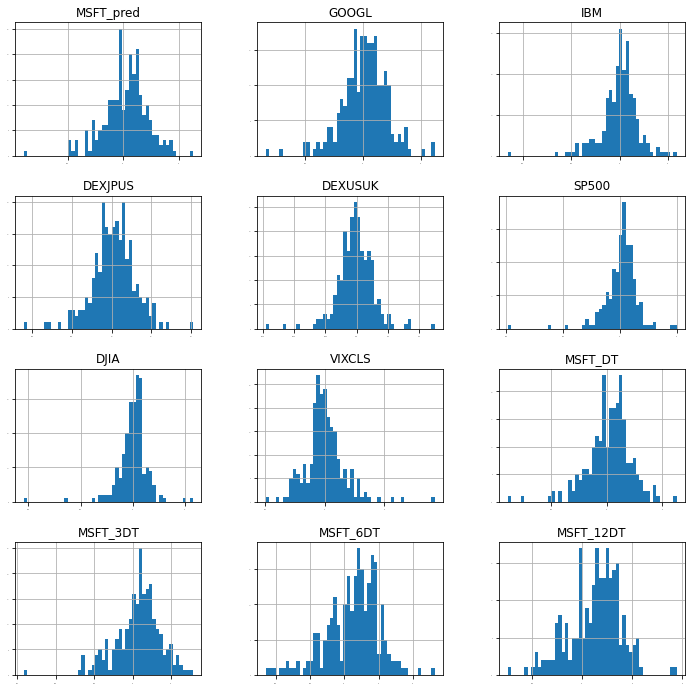

In [11]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()


The above histogram shows the distribution for each series individually. Now, lets look at the density distribution over the same x axis scale.

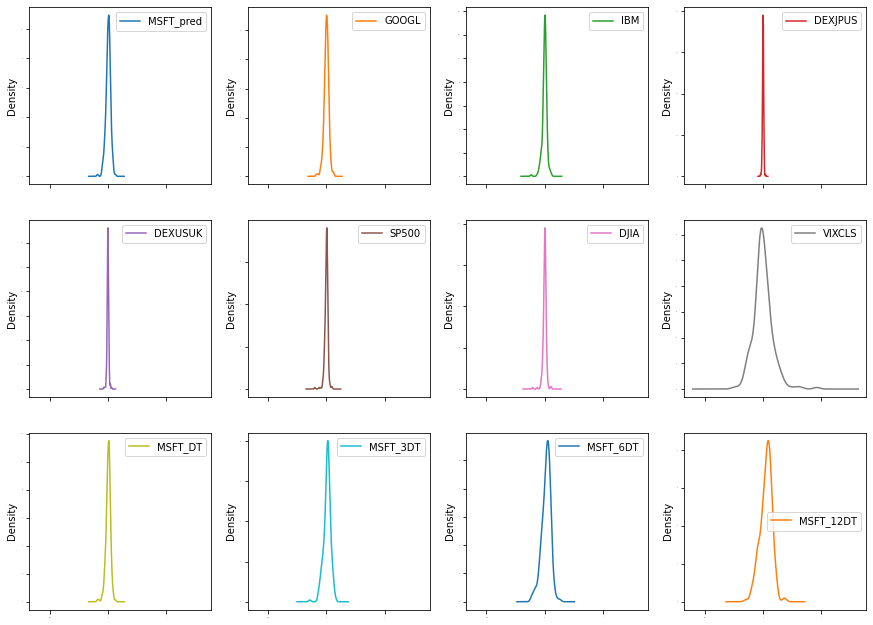

In [12]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

We can see that the vix has a much larger variance compared to the other distributions.

In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix

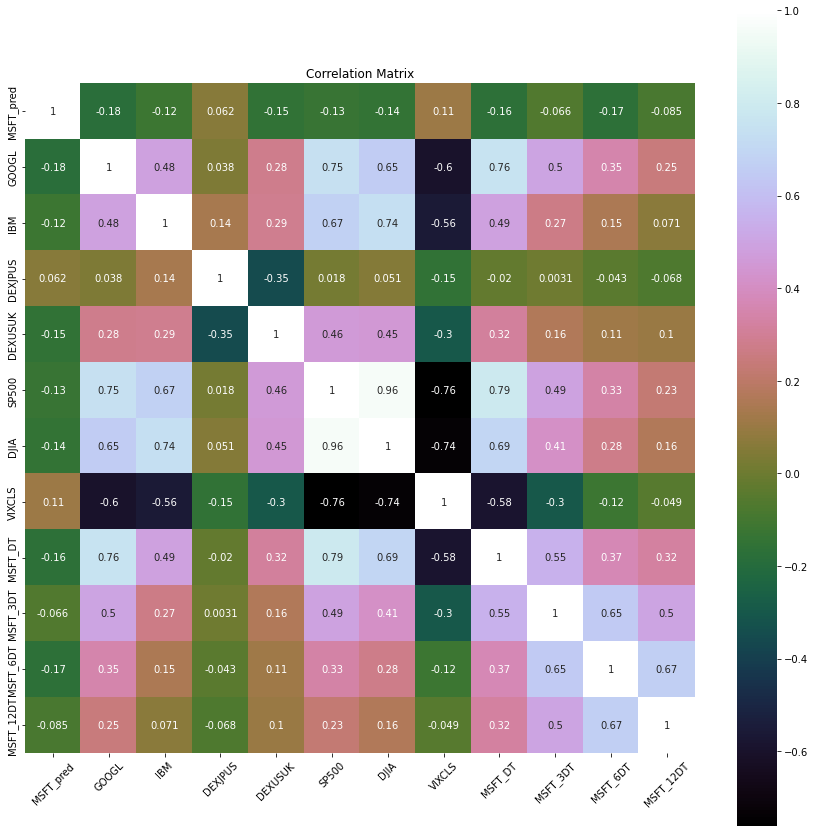

In [13]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
pyplot.xticks(rotation = 45)
# sns.heatmap(correlation, vmax=1, square=True,annot=True,linewidth=.5, cmap='cubehelix')
sns.heatmap(correlation, vmax=1, square=True,annot=True, cmap='cubehelix')

Looking at the correlation plot above, we see some correlation of the predicted variable with the lagged 5 days, 15days, 30 days and 60 days return of MSFT.

<Figure size 1440x1440 with 0 Axes>

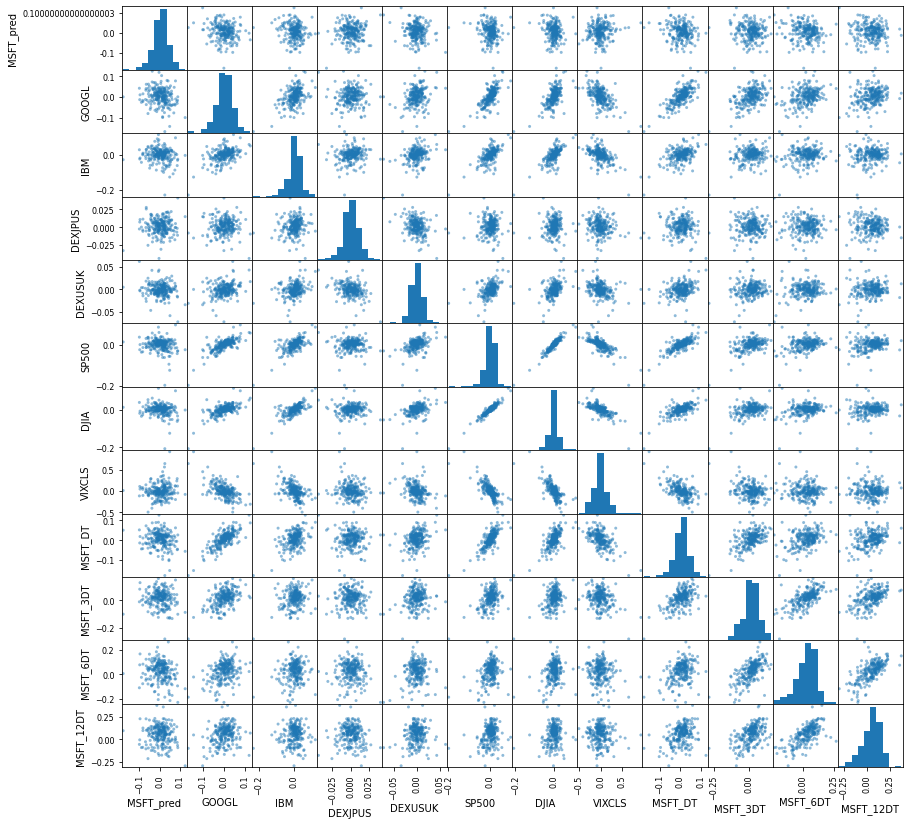

In [14]:
pyplot.figure(figsize=(20,20))
scatter_matrix(dataset,figsize=(14,14))
pyplot.show()


Looking at the scatter plot above, we see some linear relationship of the predicted variable with the lagged 15 days, 30 days and 60 days return of MSFT.

## Time Series Analysis
### Seasonal decomposition of time series

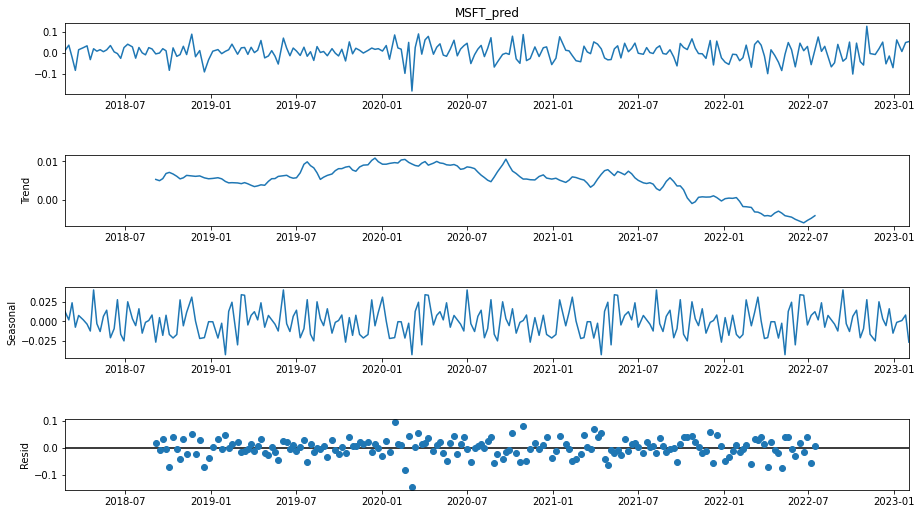

In [15]:
res = sm.tsa.seasonal_decompose(Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

# Data Preparation
## Feature Selection
We use sklearn's SelectKBest function to get a sense of feature importance.

In [16]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
GOOGL,7.642
MSFT_6DT,6.776
MSFT_DT,6.463
DEXUSUK,5.383
DJIA,4.920
SP500,4.229
IBM,3.134
VIXCLS,2.837
MSFT_12DT,1.712


SelectKBest function to get a sense of feature importance when ran on data from  "2010-03 to 2019-06"	

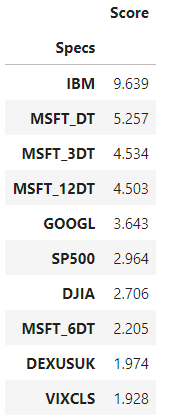

# Evaluate Algorithms and Models
## Train Test Split and Evaluation Metrics

In [17]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is dependent on the time series, then train and test split should be done based on sequential sample
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

## Test Options and Evaluation Metrics

In [18]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error' 

## Compare Models and Algorithms
### Machine Learning models-from scikit-learn

In [19]:
models = []

**Regression and Tree Regression algorithms**

In [20]:
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

**Neural Network algorithms**

In [21]:
models.append(('MLP', MLPRegressor()))

**Ensemble models**

In [22]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

We loop over each of the model. First we will run the K-fold analysis. Next we will run the model on the entire training and testing dataset.

In [23]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001354 (0.000808) 0.001134 0.002818
LASSO: 0.001328 (0.000787) 0.001326 0.002529
EN: 0.001328 (0.000787) 0.001326 0.002529
KNN: 0.001545 (0.000819) 0.000980 0.002960
CART: 0.002785 (0.001744) 0.000000 0.006449
SVR: 0.002337 (0.000561) 0.002299 0.003130
MLP: 0.002461 (0.001533) 0.003360 0.003778
ABR: 0.001442 (0.000814) 0.000716 0.004216
GBR: 0.001665 (0.000891) 0.000108 0.003986
RFR: 0.001489 (0.000959) 0.000213 0.003293
ETR: 0.001508 (0.000896) 0.000000 0.003159


## K Fold results

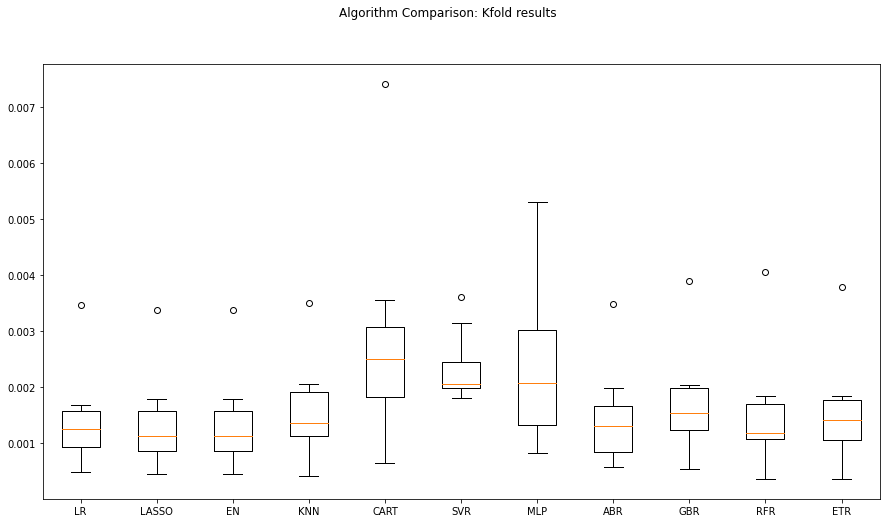

In [24]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

### **Training and Test error**

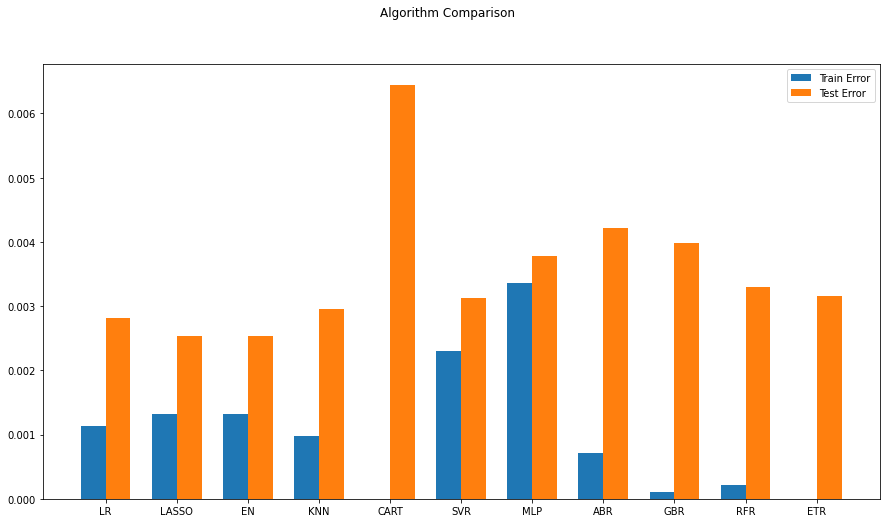

In [25]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Looking at the training and test error, we still see a better performance of the linear models. Some of the algorithms, such as the decision tree regressor (CART) overfit on the training data and produced very high error on the test set and these models should be avoided. Ensemble models, such as gradient boosting regression (GBR) and random forest regression (RFR) have low bias but high variance. We also see that the artificial neural network (shown as MLP is the chart) algorithm shows higher errors both in training set and test set, which is perhaps due to the linear relationship of the variables not captured accurately by ANN or improper hyperparameters or insuffi‐ cient training of the model.

### **Time Series based models-ARIMA and LSTM**
Let us first prepare the dataset for ARIMA models, by having only the correlated varriables as exogenous variables.
#### **Time Series Model - ARIMA Model**

In [26]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [27]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [28]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0026700170063395797

#### **LSTM Model**

In [29]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [30]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

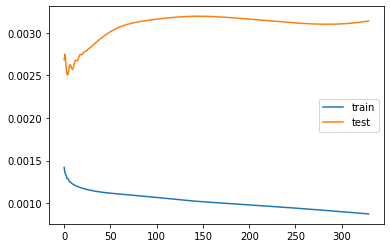

In [31]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [32]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

2/2 [==============================] - 0s 12ms/step


### Append to previous results

In [33]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

## Overall Comparison of all the algorithms ( including Time Series Algorithms)

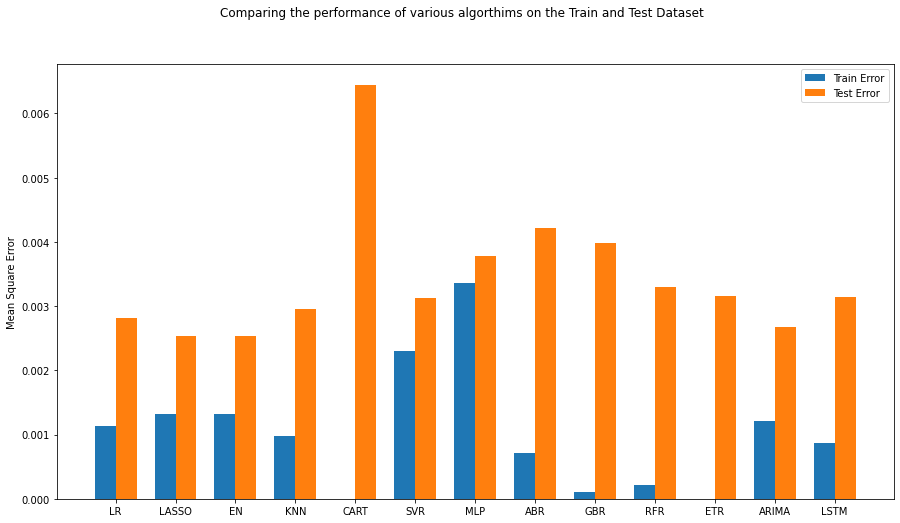

In [34]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

Looking at the chart above, we find time series based ARIMA model comparable to the linear supervised-regression models such as Linear Regression (LR), Lasso Regres‐ sion (LASSO) and Elastic Net (EN). This can primarily be due to the strong linear relationship as discussed before. The LSTM model performs decently, however, ARIMA model outperforms the LSTM model in the test set. Hence, we select the ARIMA model for the model tuning.